# <font color=gray size=5>Trabalho final SER 347 - Introdução à Programação para Sensoriamento Remoto</font>
- - -

# Reamostragem de imagens matriciais para uma grade de referência

Alunas: 
>Ana Carolina Moreira Pessôa <br>
>Nathalia Carvalho

## Introdução

<p style="text-align: justify;">Um dos desafios para se trabalhar com dados espaciais é o tempo gasto nos processamentos computacionais. A compatibilização de dados espaciais em grades celulares regulares é uma metodologia recorrente para viabilizar a análise de dados em diferentes resoluções de origem. Essa compatibilização se dá pela reamostragem do dado em sua resolução original, para uma nova resolução que será única entre todo o banco de dados. Essa reamostragem pode ocupar boa parte do tempo de processamento de seu trabalho, quando se tratando de áreas muito extensas e/ou séries temporais longas. Este trabalho propõe desenvolver um programa de reamostragem em linguagem Python, a fim de compatibilizar produtos com resoluções espaciais diferentes, bem como, obter os valores percentuais em relação aos dados originais.</p>

## Área de Estudo

<p style="text-align: justify;">A área de estudo compreende um porção do estado no Mato Grosso na parte da Amazônia Legal. A figura abaixo apresenta a localização da área de estudo.</p>

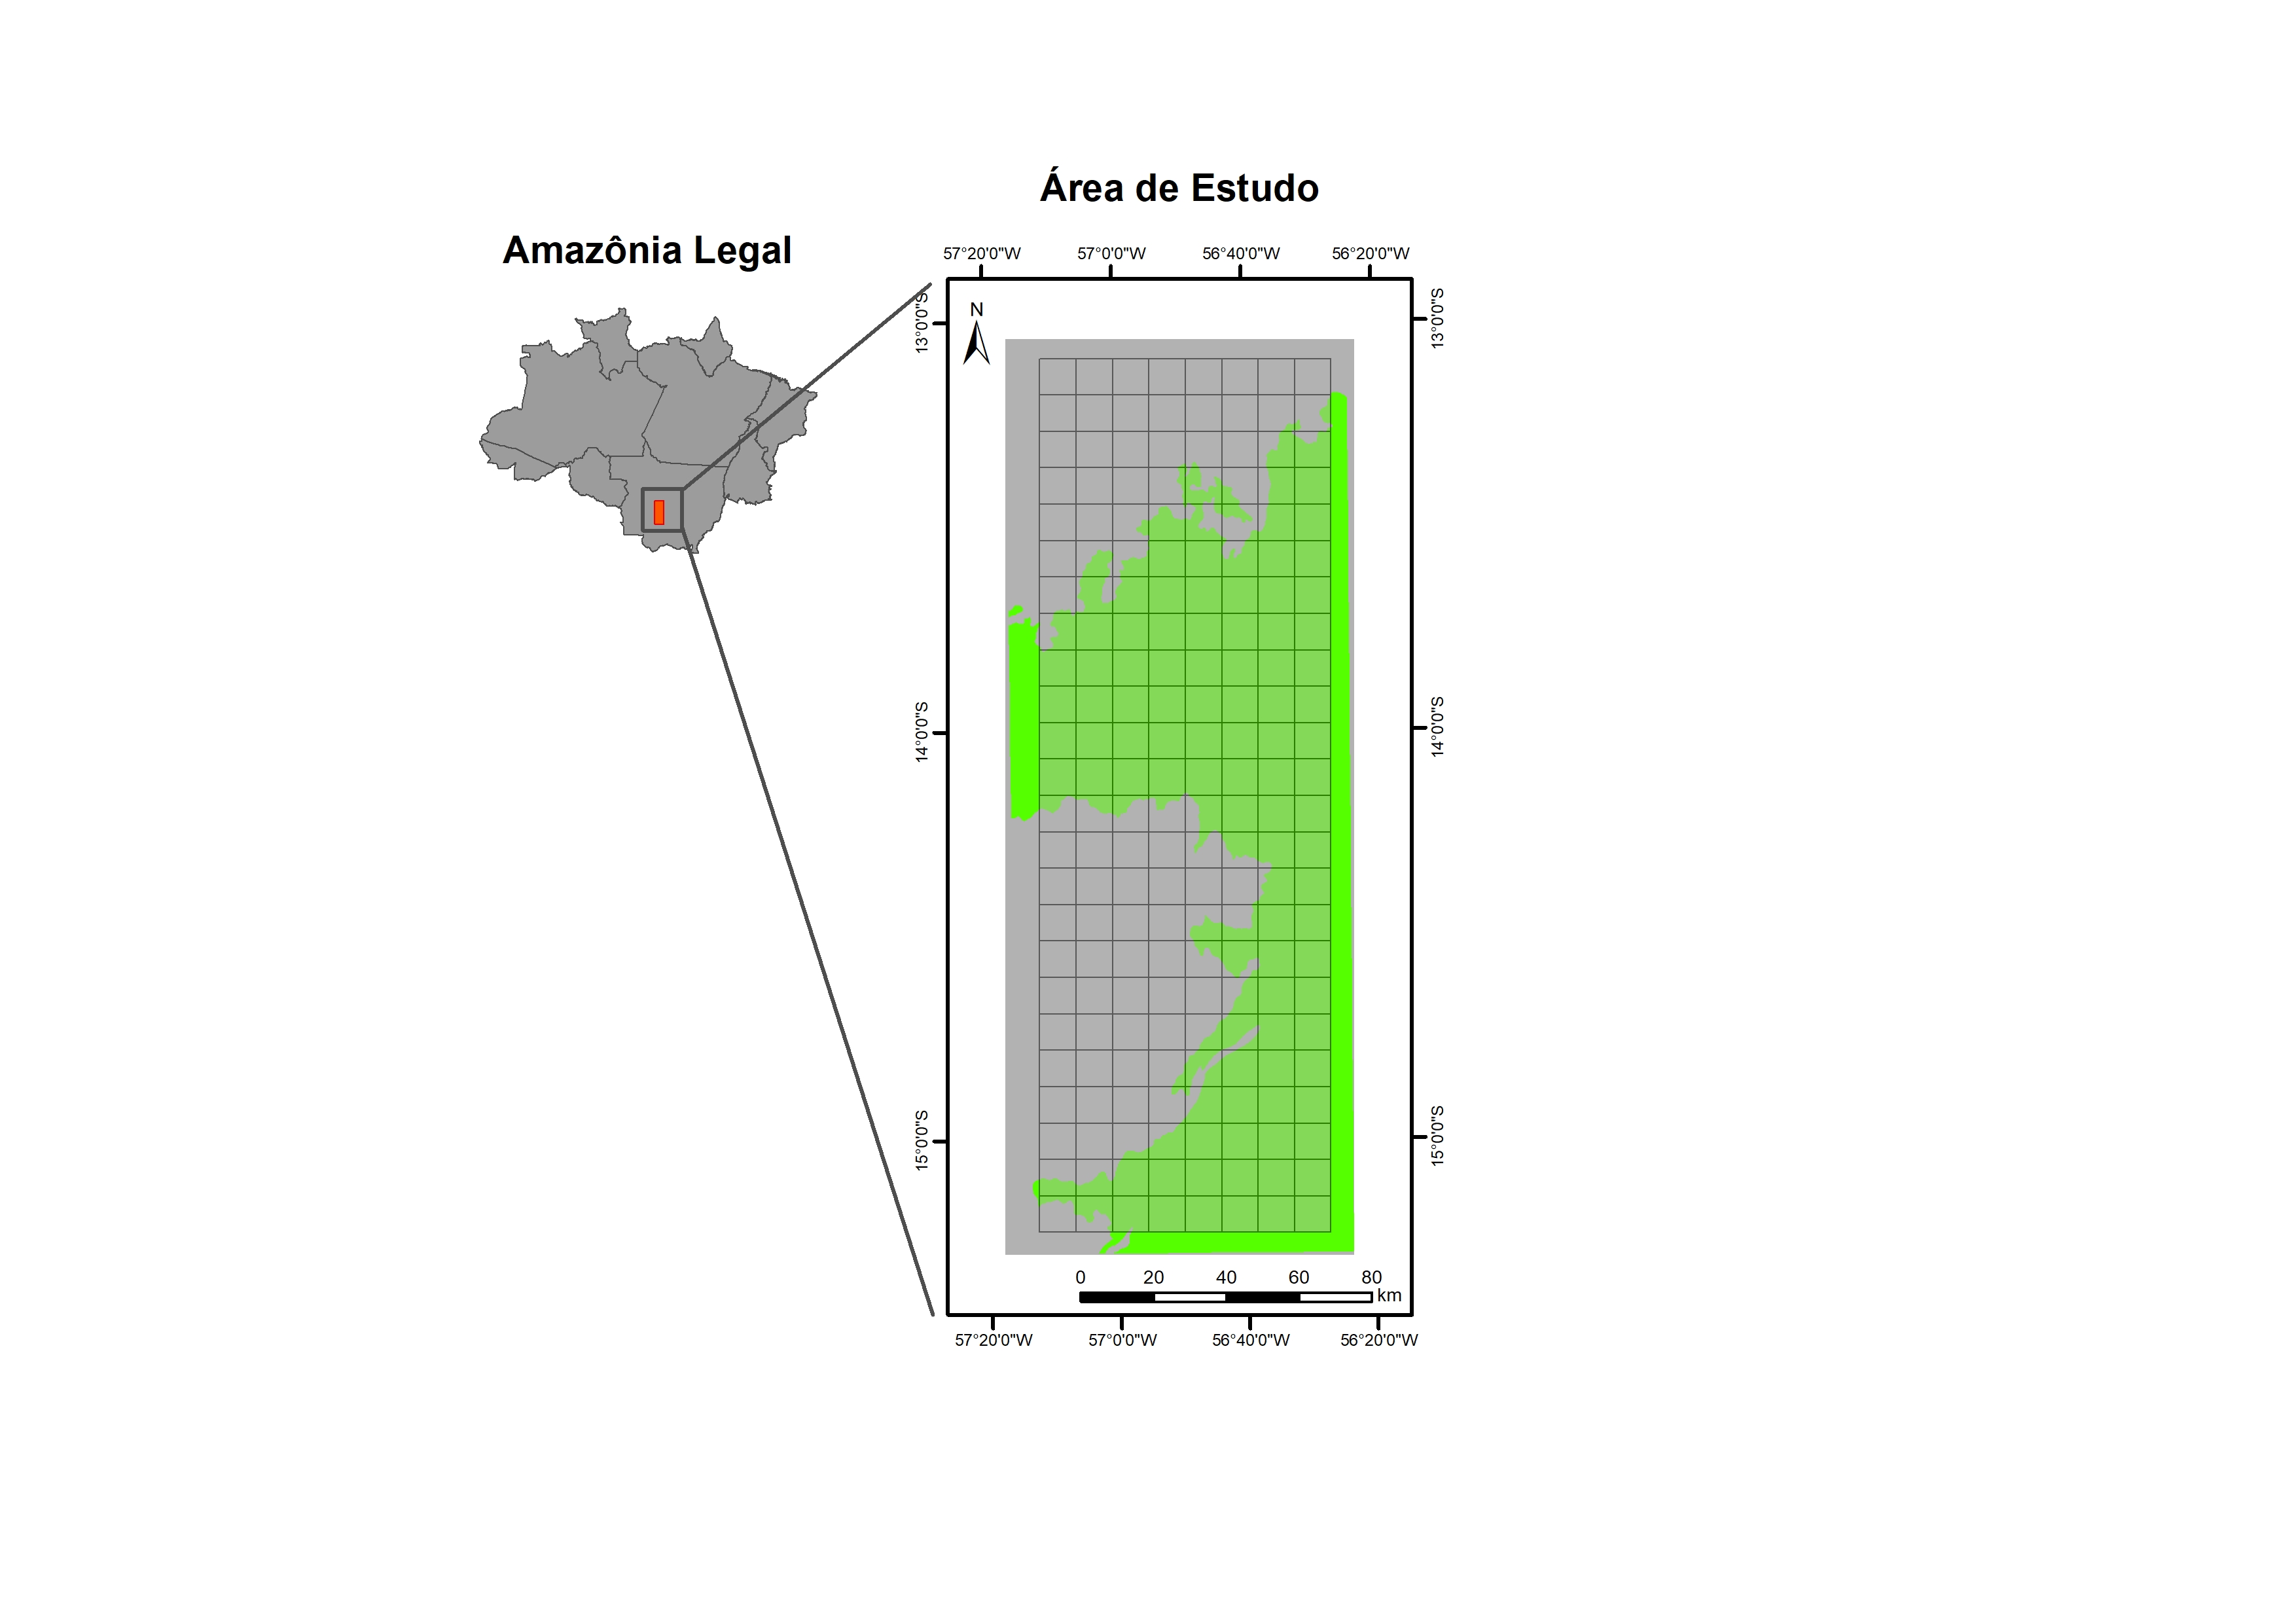

## Metodologia

<p style="text-align: justify;">Serão utilizados os dados da Coleção 2.3 do MapBiomas. Esses dados incluem informações anuais da dinâmica da cobertura do solo gerados a partir da classificação de imagens do satélite Landsat, com uma resolução espacial de 30 metros. A fim de compatibilizá-los com bancos de dados que possuem resoluções espaciais maiores, estes dados serão reamostrados para grades regulares de 1 quilômetro, 5 quilômetros e 10 quilômetros. A figura abaixo ilustra as grades regulares de referência que serão usadas na reamostragem.</p> 

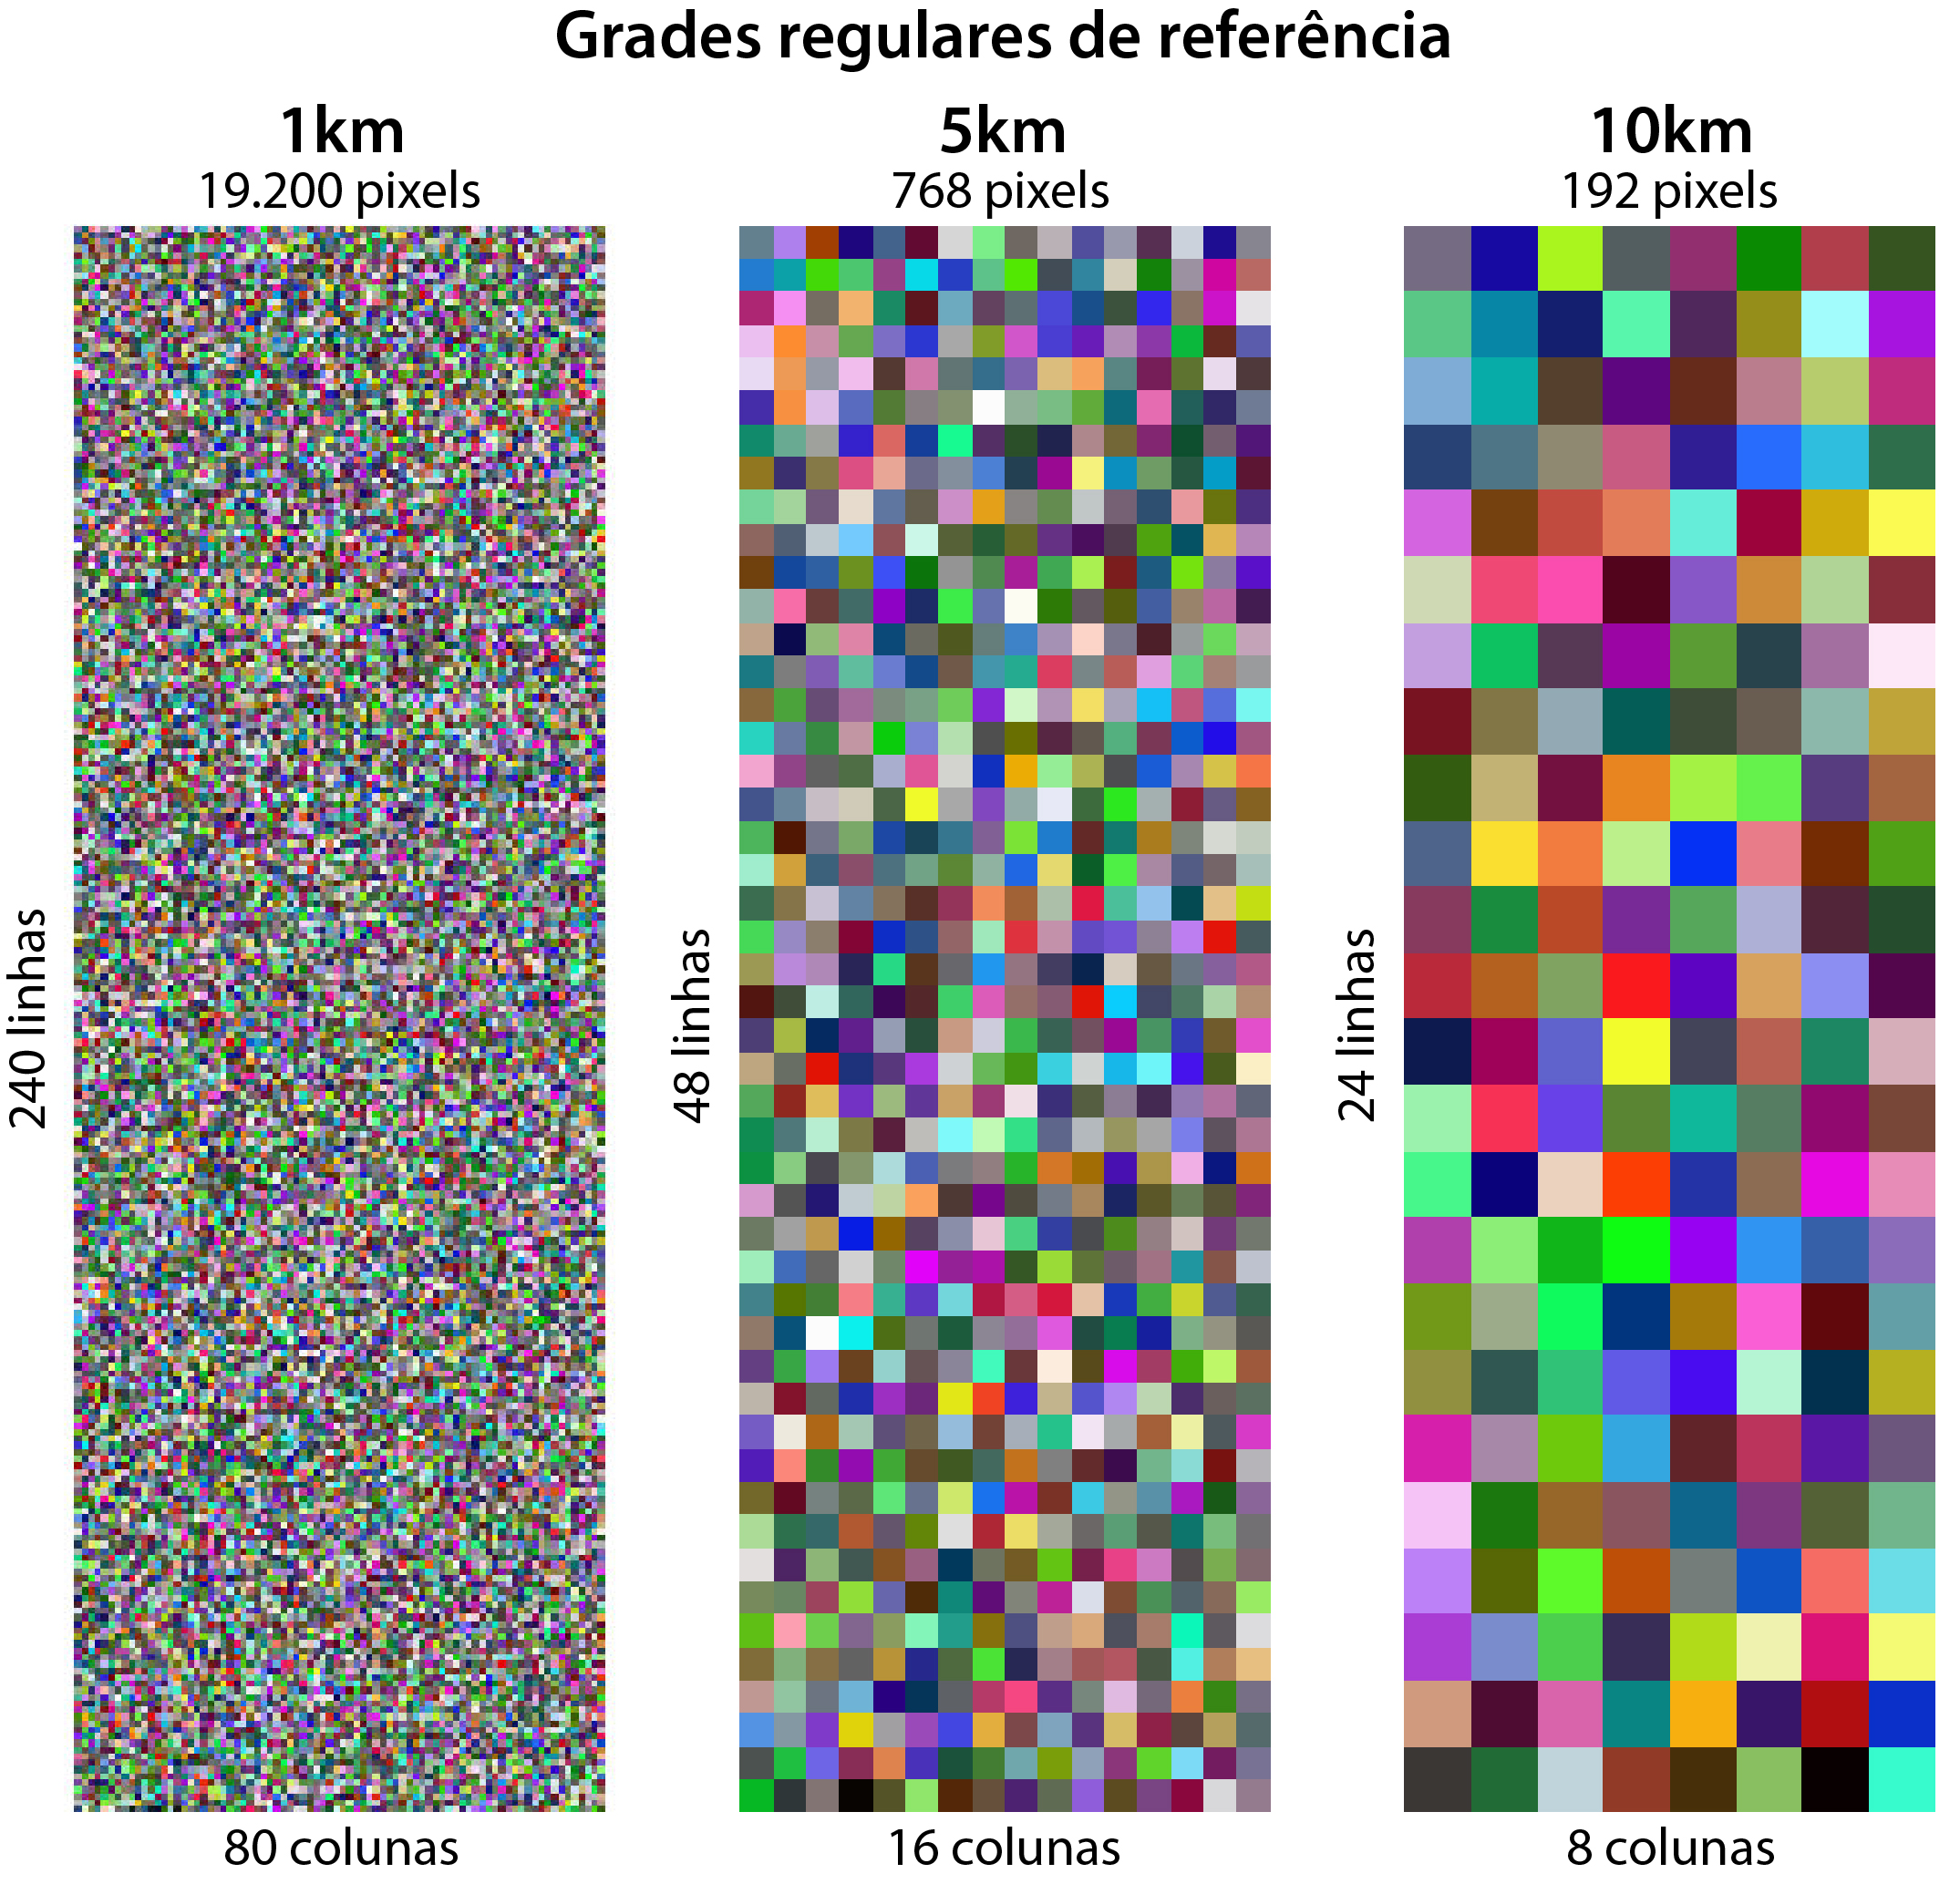

<p style="text-align: justify;">O programa deverá gerar imagens nas quais o valor de cada pixel corresponderá ao percentual de cada cobertura do solo existente na área do novo quadrante. Estas análises serão realizadas para quatro classes de cobertura do solo - Floresta, Formações naturais não florestais, Agropecuária e Outros - e para dois anos de mapeamento - 2000 e 2016. A partir dos resultados obtidos espera-se obter um programa que reduza o tempo de processamento e que otimize a extração de informações a partir de densos bancos de dados. A figura abaixo ilustra a metodologia adotada, e os passos realizados em linguagem Python (destacados no quadrante laranja).</p>

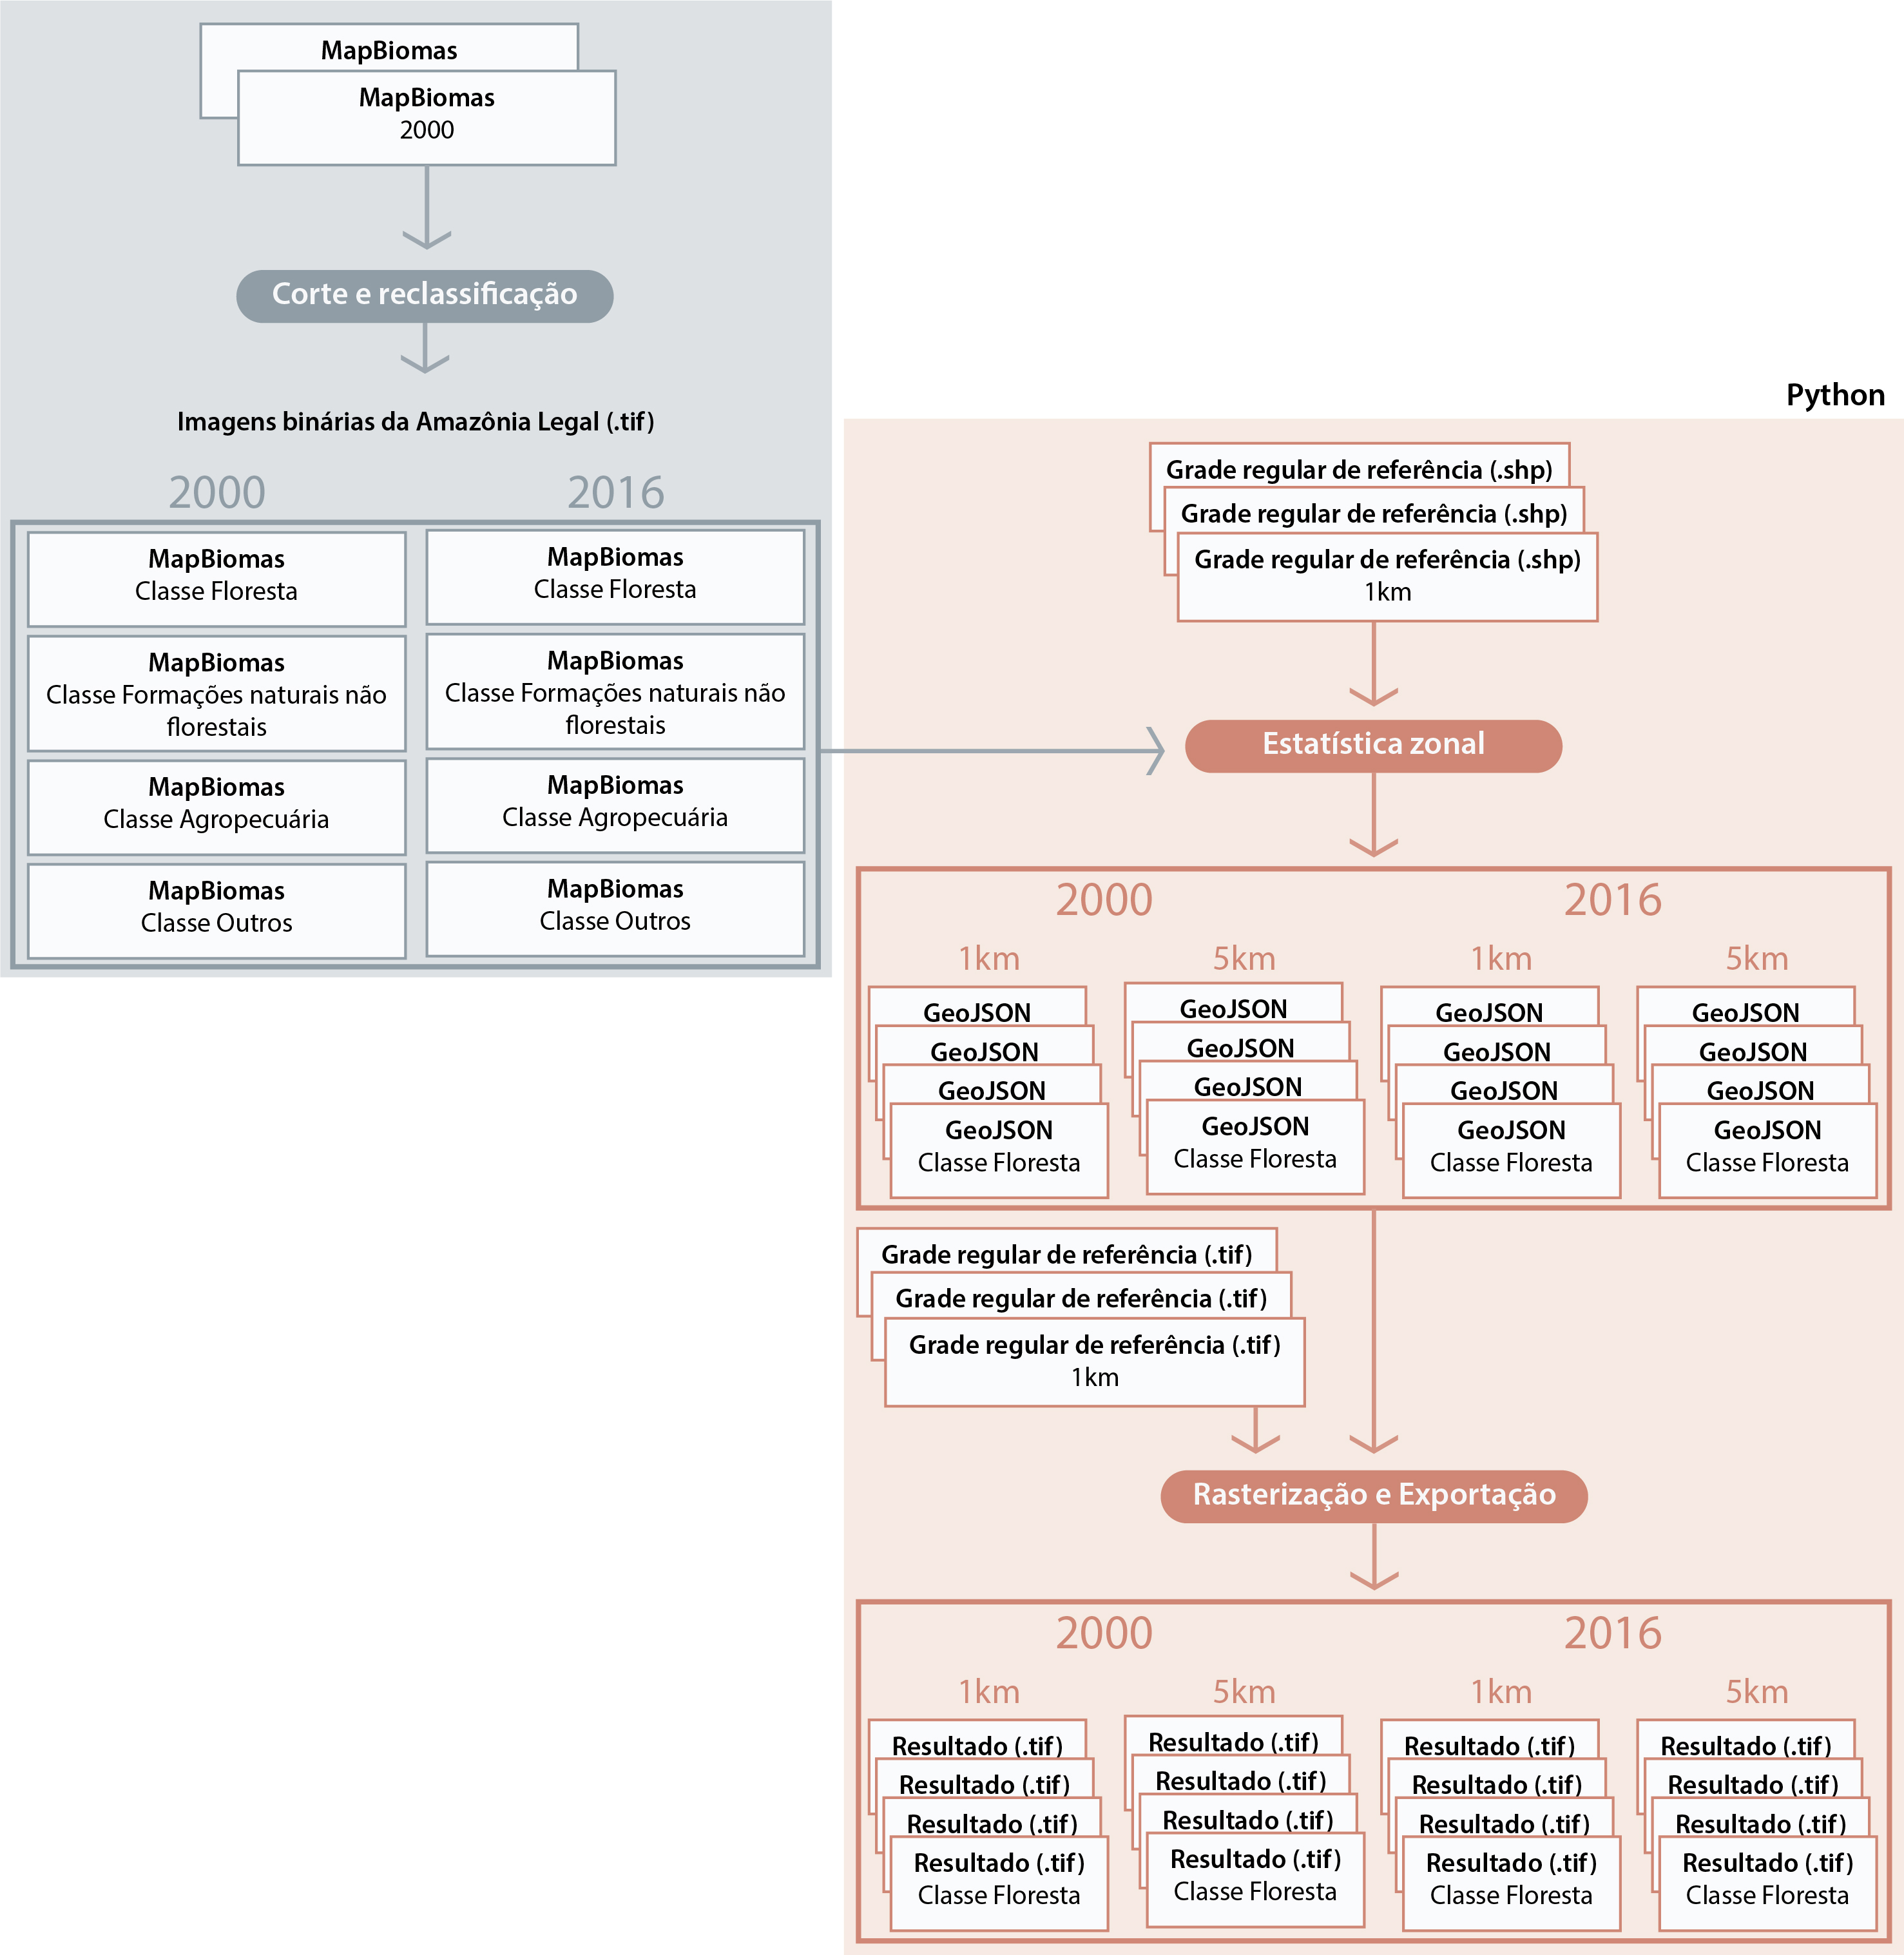

## Programação em Python 

### 1. Importação das bibliotecas 

In [17]:
import os
import rasterio 
import fiona
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely
from shapely.geometry import shape 
from osgeo import ogr
from osgeo import gdal
import subprocess
import sys
from matplotlib import pyplot as plt
# importar constantes
from gdalconst import *
# informar o uso de exceções
gdal.UseExceptions()

### 2. Manipulação dos diretórios e arquivos

#### 2.1. Definição do diretório de trabalho

In [23]:
# Imprimir diretório atual
print("Diretório de inicialização:" , os.getcwd())

# Mudar diretório
os.chdir("C:/Users/acpes/Dropbox (Pessoal)/proj_python")

print("Diretório alterado para:" , os.getcwd())

Diretório de inicialização: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados
Diretório alterado para: C:\Users\acpes\Dropbox (Pessoal)\proj_python


#### 2.2. Lista de todos os arquivos do diretório de trabalho

In [24]:
# Listar todos os arquivos dentro do diretório atual de trabalho
lista_dir = os.listdir(os.getcwd())

# Imprimir todos os arquivos existentes no diretório de trabalho
print ("Arquivos no diretório de trabalho:")
print("------------------------------")
for i in lista_dir:
    print(i)

Arquivos no diretório de trabalho:
------------------------------
.dropbox
biomas_2000_reclass_classe1_proj.tif
biomas_2000_reclass_classe2_proj.tif
biomas_2000_reclass_classe3_proj.tif
biomas_2000_reclass_classe4_proj.tif
biomas_2016_reclass_classe1_proj.tif
biomas_2016_reclass_classe2_proj.tif
biomas_2016_reclass_classe3_proj.tif
biomas_2016_reclass_classe4_proj.tif
desktop.ini
Documento
molde_10km.dbf
molde_10km.prj
molde_10km.sbn
molde_10km.sbx
molde_10km.shp
molde_10km.shx
molde_10km.tif
molde_1km.dbf
molde_1km.prj
molde_1km.sbn
molde_1km.sbx
molde_1km.shp
molde_1km.shx
molde_1km.tif
molde_5km.dbf
molde_5km.prj
molde_5km.sbn
molde_5km.sbx
molde_5km.shp
molde_5km.shx
molde_5km.tif
molde_recorte
Resultados


#### 2.3. Lista dos dados de entrada (.tif) - Imagens binárias de cada classe em cada ano 

In [4]:
# Criar variável para armazenar uma lista apenas com os arquivos .tif de entrada
lista_entrada=[]

print("Imagens de entrada com a extensão .tif:")
print("------------------------------")

# Selecionar apenas os arquivos que possuem a extensão proj.tif (8 últimos caracteres)
for i in lista_dir:
    if i[-8:]=='proj.tif':
        #armazenar os arquivos .tif na lista de entrada
        lista_entrada.append(i)
        print(i)

Imagens de entrada com a extensão .tif:
------------------------------
biomas_2000_reclass_classe1_proj.tif
biomas_2000_reclass_classe2_proj.tif
biomas_2000_reclass_classe3_proj.tif
biomas_2000_reclass_classe4_proj.tif
biomas_2016_reclass_classe1_proj.tif
biomas_2016_reclass_classe2_proj.tif
biomas_2016_reclass_classe3_proj.tif
biomas_2016_reclass_classe4_proj.tif


#### 2.4. Lista dos diretórios dos dados de entrada

In [9]:
# Criar lista com strings dos diretórios das imagens de entrada - Essa lista será utilizada para a análise de estatísticas zonais

lista_entrada_dir = []

print("Diretório das imagens de entrada com a extensão .tif:")
print("------------------------------")

for i in lista_entrada:
    file = os.path.abspath(i)
    print(file)
    lista_entrada_dir.append(file)

Diretório das imagens de entrada com a extensão .tif:
------------------------------
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe1_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe2_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe3_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe4_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe1_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe2_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe3_proj.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe4_proj.tif


### 3. Leitura dos arquivos vetoriais dos moldes


In [6]:
# Grades regulares de referência de 1km, 5km, 10km

molde_1km = fiona.open("C:/Users/acpes/Dropbox (Pessoal)/proj_python/molde_1km.shp") 
molde_5km = fiona.open("C:/Users/acpes/Dropbox (Pessoal)/proj_python/molde_5km.shp") 
molde_10km = fiona.open("C:/Users/acpes/Dropbox (Pessoal)/proj_python/molde_10km.shp") 

### 4. Estatística zonal

In [13]:
# Criar uma lista que dará o nome aos arquivos gerados

nomes = ["ano2000_classe1","ano2000_classe2","ano2000_classe3","ano2000_classe4","ano2016_classe1","ano2016_classe2","ano2016_classe3","ano2016_classe4"]

# Conferir se cada nome corresponde ao arquivo de entrada
for i, nome in zip(lista_entrada_dir, nomes):
    print(i, nome)

C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe1_proj.tif ano2000_classe1
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe2_proj.tif ano2000_classe2
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe3_proj.tif ano2000_classe3
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2000_reclass_classe4_proj.tif ano2000_classe4
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe1_proj.tif ano2016_classe1
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe2_proj.tif ano2016_classe2
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe3_proj.tif ano2016_classe3
C:\Users\acpes\Dropbox (Pessoal)\proj_python\biomas_2016_reclass_classe4_proj.tif ano2016_classe4


#### 4.1. Grade regular de referência de 1km

In [16]:
%%timeit

# Aplicar função da estatística zonal para obter a proporção de cada classe em cada ano para a grade de referência de 1km
for i, nome in zip(lista_entrada_dir, nomes):
        zonal = zonal_stats(molde_1km, i, band=1, stats=['mean'], all_touched = False, geojson_out=True)
        dataframe = GeoDataFrame.from_features(zonal)
        dataframe.to_file("C:/Users/acpes/Dropbox (Pessoal)/proj_python/Resultados/"+nome+"_1km.shp")
        

C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


2min 58s ± 15.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 4.2. Grade regular de referência de 5km

In [15]:
%%timeit

# Aplicar função da estatística zonal para obter a proporção de cada classe em cada ano para a grade de referência de 5km
for i, nome in zip(lista_entrada_dir, nomes):
        zonal = zonal_stats(molde_5km, i, band=1, stats=['mean'], all_touched = False, geojson_out=True)
        dataframe = GeoDataFrame.from_features(zonal)
        dataframe.to_file("C:/Users/acpes/Dropbox (Pessoal)/proj_python/Resultados/"+nome+"_5km.shp")

C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


12.2 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 4.3. Grade regular de referência de 10km

In [14]:
%%timeit

# Aplicar função da estatística zonal para obter a proporção de cada classe em cada ano para a grade de referência de 10km
for i, nome in zip(lista_entrada_dir, nomes):
        zonal = zonal_stats(molde_10km, i, band=1, stats=['mean'], all_touched = False, geojson_out=True)
        dataframe = GeoDataFrame.from_features(zonal)
        dataframe.to_file("C:/Users/acpes/Dropbox (Pessoal)/proj_python/Resultados/"+nome+"_10km.shp")
        

C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
C:\Users\acpes\Anaconda3\envs\geospatial\lib\site-packages\rasterstats\main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


6.54 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 5. Rasterização e exportação do produto final

<p style="text-align: justify;">Para gerar o produto final, ou seja, rasters com proporção de cada classe em cada ano, será preciso gerar três listas com os diretórios para:</p>

1. Os vetores de entrada - gerado na etapa da estatística zonal
2. Os rasters de referência - moldes do raster que queremos gerar. Foram usadas as mesmas grades regulares de referência da etapa anterior rasterizadas.
3. Os rasters de saída

<p style="text-align: justify;">Uma vez criadas essas listas, será usada função 'vetoraster' para rasterizar os vetores de entrada e salvar o produto final no diretório dos resultados.</p> 

#### 5.1. Definição da função 'vetoraster'

In [37]:
def vetoraster (vetor_entrada, raster_referencia, raster_saida):

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Float32
    ##########################################################
    # Extrair informação da projeção do raster de referência
    Image = gdal.Open(raster_referencia, gdal.GA_ReadOnly)

    # Abrir vetor de entrada
    Shapefile = ogr.Open(vetor_entrada)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterizar
    print("Rasterizando o vetor de entrada...")
    Output = gdal.GetDriverByName(gdalformat).Create(raster_saida, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Atribuir dado à banda 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(255)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, options = ["ATTRIBUTE=MEAN"])

    # Fechar dados
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Construção da imagem 
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+raster_saida+" 2 4 8 16 32 64", shell=True)
    print("Done.")

#### 5.2. Definição da lista dos rasters de referência

In [26]:
# Criar lista vazia para armazenar os rasters de referência

lista_raster_referencia=[]

print("Rasters de referência com a extensão .tif:")
print("------------------------------")

# Selecionar apenas os arquivos que possuem o padrão km.shp (6 últimos caracteres)
for i in lista_dir:
    if i[-6:]=='km.tif':
        #armazenar os arquivos .tif na lista de rasters de referência
        lista_raster_referencia.append(i)
        print(i)

Rasters de referência com a extensão .tif:
------------------------------
molde_10km.tif
molde_1km.tif
molde_5km.tif


In [27]:
# Criar lista com strings dos diretórios dos rasters de referência

lista_raster_referencia_dir = []

print("Diretório dos rasters de referência com a extensão .tif:")
print("------------------------------")

for i in lista_raster_referencia:
    file = os.path.abspath(i)
    print(file)
    lista_raster_referencia_dir.append(file)

Diretório dos rasters de referência com a extensão .tif:
------------------------------
C:\Users\acpes\Dropbox (Pessoal)\proj_python\molde_10km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\molde_1km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\molde_5km.tif


#### 5.3. Definição da lista dos vetores de entrada

In [29]:
# Imprimir diretório atual
print("Diretório de inicialização:" , os.getcwd())

# Mudar diretório
os.chdir("C:/Users/acpes/Dropbox (Pessoal)/proj_python/Resultados")

print("Diretório alterado para:" , os.getcwd())

# Listar todos os arquivos dentro do diretório atual de trabalho
lista_dir = os.listdir(os.getcwd())

Diretório de inicialização: C:\Users\acpes\Dropbox (Pessoal)\proj_python
Diretório alterado para: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados


In [30]:
# Criar lista vazia para armazenar os vetores de entrada

lista_vetor_entrada=[]

print("Vetores de entrada com a extensão .shp:")
print("------------------------------")

# Selecionar apenas os arquivos que possuem o padrão km.shp (6 últimos caracteres)
for i in lista_dir:
    if i[-6:]=='km.shp':
        #armazenar os arquivos .shp na lista de vetores de entrada
        lista_vetor_entrada.append(i)
        print(i)

Vetores de entrada com a extensão .shp:
------------------------------
ano2000_classe1_10km.shp
ano2000_classe1_1km.shp
ano2000_classe1_5km.shp
ano2000_classe2_10km.shp
ano2000_classe2_1km.shp
ano2000_classe2_5km.shp
ano2000_classe3_10km.shp
ano2000_classe3_1km.shp
ano2000_classe3_5km.shp
ano2000_classe4_10km.shp
ano2000_classe4_1km.shp
ano2000_classe4_5km.shp
ano2016_classe1_10km.shp
ano2016_classe1_1km.shp
ano2016_classe1_5km.shp
ano2016_classe2_10km.shp
ano2016_classe2_1km.shp
ano2016_classe2_5km.shp
ano2016_classe3_10km.shp
ano2016_classe3_1km.shp
ano2016_classe3_5km.shp
ano2016_classe4_10km.shp
ano2016_classe4_1km.shp
ano2016_classe4_5km.shp


In [31]:
# Criar lista com strings dos diretórios dos vetores de entrada

lista_vetor_entrada_dir = []

print("Diretório dos vetores de entrada com a extensão .shp:")
print("------------------------------")

for i in lista_vetor_entrada:
    file = os.path.abspath(i)
    print(file)
    lista_vetor_entrada_dir.append(file)

Diretório dos vetores de entrada com a extensão .shp:
------------------------------
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_10km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_1km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_5km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_10km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_1km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_5km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_10km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_1km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_5km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_10km.shp
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_1km.shp
C:\Users\acpes\Dropbox (Pessoal

#### 5.4. Definição da lista dos rasters de saída

In [28]:
# Criar lista vazia que receberá nomes dos diretórios dos rasters de saída

lista_raster_saida_dir = []

print("Diretório dos rasters de saída com a extensão .tif:")
print("------------------------------")

for i in lista_vetor_entrada_dir:
    file = i.replace(".shp", ".tif")
    print(file)
    lista_raster_saida_dir.append(file)

Diretório dos rasters de saída com a extensão .tif:
------------------------------
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_10km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_1km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_5km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_10km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_1km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_5km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_10km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_1km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe3_5km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_10km.tif
C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_1km.tif
C:\Users\acpes\Dropbox (Pessoal)\

#### 5.4. Aplicação da função 'vetoraster'

In [34]:
# Conferir se cada nome de saída corresponde ao arquivo de entrada
for entrada, saida in zip(lista_vetor_entrada_dir, lista_raster_saida_dir):
    print(entrada[-24:], saida[-24:])

ano2000_classe1_10km.shp ano2000_classe1_10km.tif
\ano2000_classe1_1km.shp \ano2000_classe1_1km.tif
\ano2000_classe1_5km.shp \ano2000_classe1_5km.tif
ano2000_classe2_10km.shp ano2000_classe2_10km.tif
\ano2000_classe2_1km.shp \ano2000_classe2_1km.tif
\ano2000_classe2_5km.shp \ano2000_classe2_5km.tif
ano2000_classe3_10km.shp ano2000_classe3_10km.tif
\ano2000_classe3_1km.shp \ano2000_classe3_1km.tif
\ano2000_classe3_5km.shp \ano2000_classe3_5km.tif
ano2000_classe4_10km.shp ano2000_classe4_10km.tif
\ano2000_classe4_1km.shp \ano2000_classe4_1km.tif
\ano2000_classe4_5km.shp \ano2000_classe4_5km.tif
ano2016_classe1_10km.shp ano2016_classe1_10km.tif
\ano2016_classe1_1km.shp \ano2016_classe1_1km.tif
\ano2016_classe1_5km.shp \ano2016_classe1_5km.tif
ano2016_classe2_10km.shp ano2016_classe2_10km.tif
\ano2016_classe2_1km.shp \ano2016_classe2_1km.tif
\ano2016_classe2_5km.shp \ano2016_classe2_5km.tif
ano2016_classe3_10km.shp ano2016_classe3_10km.tif
\ano2016_classe3_1km.shp \ano2016_classe3_1km.tif


In [39]:
for ref in lista_raster_referencia_dir:
    print('Raster de referência:', ref)
    for entrada, saida in zip(lista_vetor_entrada_dir, lista_raster_saida_dir):
        print('Vetor de entrada:', entrada)
        print('Raster de saída:', saida)
        vetoraster(entrada, ref, saida)

Raster de referência: C:\Users\acpes\Dropbox (Pessoal)\proj_python\molde_10km.tif
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_10km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_10km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_1km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_1km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_5km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe1_5km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_10km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe2_10km.tif
Rasterizand

Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_5km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2000_classe4_5km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_10km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_10km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_1km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_1km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_5km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe1_5km.tif
Rasterizando o vetor de entrada...
Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoa

Done.
Vetor de entrada: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe4_5km.shp
Raster de saída: C:\Users\acpes\Dropbox (Pessoal)\proj_python\Resultados\ano2016_classe4_5km.tif
Rasterizando o vetor de entrada...
Done.


### 6. Produto Final

Será mostrado a reamostragem da classe Floresta para o ano 2000 para as três resoluções adotadas. A figura abaixo apresenta o raster final sobreposto ao dado original do MapBiomas em 30 metros.

#### 6.1. Reamostragem da classe Floresta do ano 2000

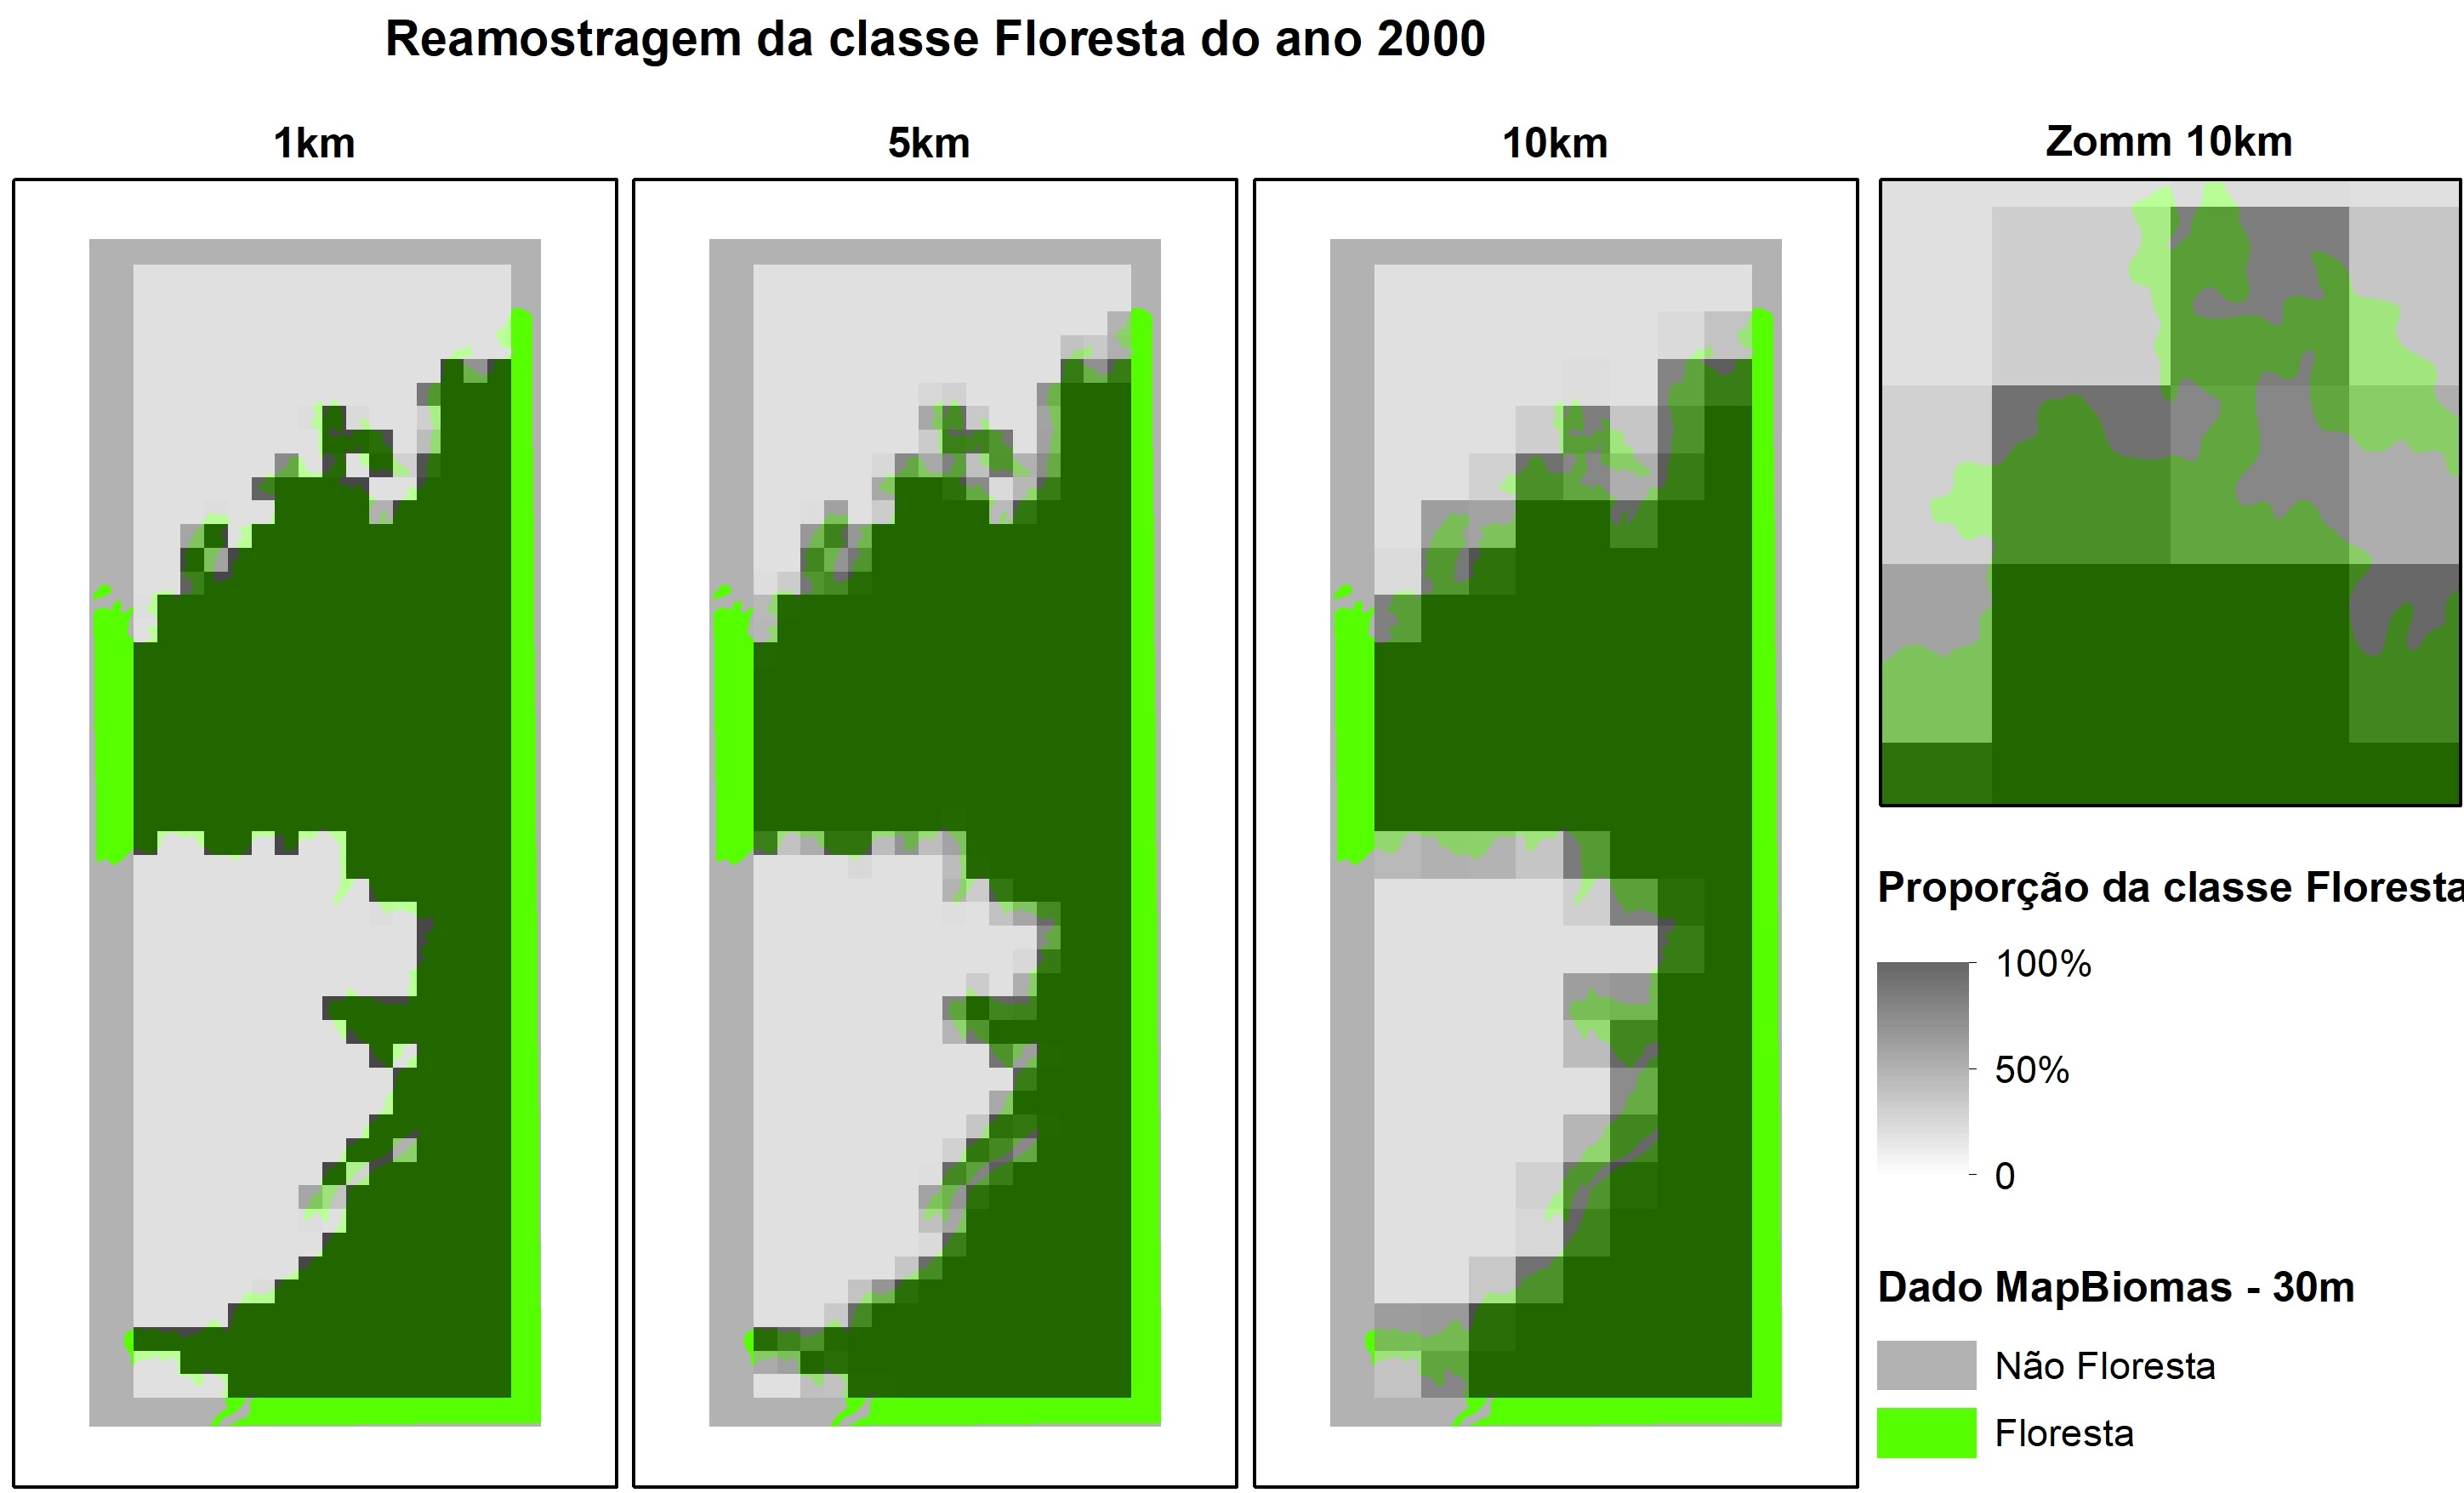

# FIM!